# Multistage Stochastic Unit Commitment Problem

In [82]:
import gurobipy as gp
import networkx as nx
import numpy as np

from sddip import parameters, tree

## Parameters

In [83]:
test_case_name = "WB3"

params = parameters.Parameters(test_case_name)

bus_df = params.bus_df
branch_df = params.bus_df
gen_df = params.bus_df
gen_cost_df = params.bus_df
ren_df = params.bus_df
storage_df = params.bus_df
scenario_df = params.scenario_df

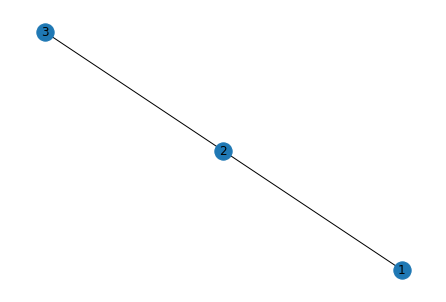

In [84]:
edges = params.branch_df[["fbus", "tbus"]].values.tolist()

g = nx.Graph(edges)
nx.draw(g, with_labels=True)

In [85]:
########################################################################################################################
# Deterministic parameters
########################################################################################################################
gc = params.gc
suc = params.suc
sdc = params.sdc
pg_min = params.pg_min
pg_max = params.pg_max
pl_max = params.pl_max

n_gens = params.n_gens

ptdf = params.ptdf

n_lines, n_buses = ptdf.shape

# Lists of generators at each bus
#
# Example: [[0,1], [], [2]]
# Generator 1 & 2 are located at bus 1
# No Generator is located at bus 2
# Generator 3 is located at bus 3
gens_at_bus = params.gens_at_bus

rg_up_max = params.r_up
rg_down_max = params.r_down

min_up_time = params.min_up_time
min_down_time = params.min_down_time

penalty = params.penalty

n_storages = params.n_storages
storages_at_bus = params.storages_at_bus

rc_max = params.rc_max
rdc_max = params.rdc_max
soc_max = params.soc_max

eff_c = params.eff_c
eff_dc = params.eff_dc


########################################################################################################################
# Stochastic parameters
########################################################################################################################
n_realizations_per_stage = params.n_realizations_per_stage
n_stages = params.n_stages

prob = params.prob
p_d = params.p_d
re = params.re

########################################################################################################################
# Expected values of stochastic parameters
########################################################################################################################
ex_pd = [np.array(prob[t]).dot(np.array(p_d[t])) for t in range(n_stages)]

In [86]:
ptdf

array([[ 0., -1., -1.],
       [ 0.,  0., -1.]])

In [87]:
params.pl_max

[990000, 990000]

In [88]:
params.incidence_matrix

array([[ 1., -1.,  0.],
       [ 0.,  1., -1.]])

In [89]:
# prob[t][n]
# Probability of realization n at stage t
# prob

In [90]:
# p_d[t][n][b]
# Demand in stage t and realization n at bus b
# p_d

In [91]:
# ex_pd[t][b]
# Expected demand in stage t at bus b
# ex_pd

In [92]:
scenario_tree = tree.ScenarioTree(n_realizations_per_stage)
print(scenario_tree)

ScenarioTree: Stages = 2, Nodes = 4


## Optimization

### Variables

In [93]:
model = gp.Model("MSUC")

x = {}
y = {}
s_up = {}
s_down = {}
ys_p = {}
ys_n = {}
ys_charge = {}
ys_discharge = {}
u = {}
soc = {}


for t in range(n_stages):
    for node in scenario_tree.get_stage_nodes(t):
        n = node.index
        for g in range(n_gens):
            x[t, n, g] = model.addVar(
                vtype=gp.GRB.BINARY, name=f"x_{t+1}_{n+1}_{g+1}"
            )
            y[t, n, g] = model.addVar(
                vtype=gp.GRB.CONTINUOUS, lb=0, name=f"y_{t+1}_{n+1}_{g+1}"
            )
            s_up[t, n, g] = model.addVar(
                vtype=gp.GRB.BINARY, name=f"s_up_{t+1}_{n+1}_{g+1}"
            )
            s_down[t, n, g] = model.addVar(
                vtype=gp.GRB.BINARY, name=f"s_down_{t+1}_{n+1}_{g+1}"
            )
        for s in range(n_storages):
            ys_charge[t, n, s] = model.addVar(
                vtype=gp.GRB.CONTINUOUS, lb=0, name=f"ys_c_{t+1}_{n+1}_{s+1}"
            )
            ys_discharge[t, n, s] = model.addVar(
                vtype=gp.GRB.CONTINUOUS, lb=0, name=f"ys_d_{t+1}_{n+1}_{s+1}"
            )
            u[t, n, s] = model.addVar(
                vtype=gp.GRB.BINARY, name=f"u_{t+1}_{n+1}_{s+1}"
            )
            soc[t, n, s] = model.addVar(
                vtype=gp.GRB.CONTINUOUS, lb=0, name=f"soc_{t+1}_{n+1}_{s+1}"
            )
        ys_p[t, n] = model.addVar(
            vtype=gp.GRB.CONTINUOUS, lb=0, name=f"ys_p_{t+1}_{n+1}"
        )
        ys_n[t, n] = model.addVar(
            vtype=gp.GRB.CONTINUOUS, lb=0, name=f"ys_n_{t+1}_{n+1}"
        )

model.update()

### Constraints

In [94]:
# Objective
conditional_probabilities = []
p = 1
for n in range(scenario_tree.n_stages):
    p = p * 1 / n_realizations_per_stage[n]
    conditional_probabilities.append(p)

obj = gp.quicksum(
    conditional_probabilities[t]
    * (gc[g] * y[t, n, g] + suc[g] * s_up[t, n, g] + sdc[g] * s_down[t, n, g])
    for t in range(n_stages)
    for n in range(scenario_tree.n_nodes_per_stage[t])
    for g in range(n_gens)
) + gp.quicksum(
    conditional_probabilities[t] * penalty * (ys_p[t, n] + ys_n[t, n])
    for t in range(n_stages)
    for n in range(scenario_tree.n_nodes_per_stage[t])
)

model.setObjective(obj)


# Balance constraints
bc = model.addConstrs(
    (
        gp.quicksum(y[t, n.index, g] for g in range(n_gens))
        + gp.quicksum(
            eff_dc[s] * ys_discharge[t, n.index, s] - ys_charge[t, n.index, s]
            for s in range(n_storages)
        )
        + ys_p[t, n.index]
        - ys_n[t, n.index]
        == gp.quicksum(p_d[t][n.realization])
        - gp.quicksum(re[t][n.realization])
        for t in range(n_stages)
        for n in scenario_tree.get_stage_nodes(t)
    ),
    "balance",
)


# Generator constraints
model.addConstrs(
    (
        y[t, n, g] >= pg_min[g] * x[t, n, g]
        for g in range(n_gens)
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ),
    "min-generation",
)

model.addConstrs(
    (
        y[t, n, g] <= pg_max[g] * x[t, n, g]
        for g in range(n_gens)
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ),
    "max-generation",
)


# Storage constraints
model.addConstrs(
    (
        ys_charge[t, n, s] <= rc_max[s] * u[t, n, s]
        for s in range(n_storages)
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ),
    "max-charge-rate",
)

model.addConstrs(
    (
        ys_discharge[t, n, s] <= rdc_max[s] * (1 - u[t, n, s])
        for s in range(n_storages)
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ),
    "max-discharge-rate",
)

model.addConstrs(
    (
        soc[t, n, s] <= soc_max[s]
        for s in range(n_storages)
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ),
    "max-soc",
)

# SOC transfer
# t=0
soc_init = [0.5 * s for s in soc_max]
model.addConstrs(
    (
        soc[0, 0, s]
        == soc_init[s] + eff_c[s] * ys_charge[0, 0, s] - ys_discharge[0, 0, s]
        for s in range(n_storages)
    ),
    "soc",
)
# t>0
for t in range(1, n_stages):
    for node in scenario_tree.get_stage_nodes(t):
        n = node.index
        a_n = node.parent.index
        model.addConstrs(
            (
                soc[t, n, s]
                == soc[t - 1, a_n, s]
                + eff_c[s] * ys_charge[t, n, s]
                - ys_discharge[t, n, s]
                for s in range(n_storages)
            ),
            "soc",
        )
# t=T
t = params.n_stages - 1
model.addConstrs(
    soc[t, n.index, s] == soc_init[s]
    for s in range(params.n_storages)
    for n in scenario_tree.get_stage_nodes(t)
)

# Power flow constraints
for t in range(n_stages):
    for node in scenario_tree.get_stage_nodes(t):
        n = node.index
        line_flows = [
            gp.quicksum(
                ptdf[l, b]
                * (
                    gp.quicksum(y[t, n, g] for g in gens_at_bus[b])
                    + gp.quicksum(
                        eff_dc[s] * ys_discharge[t, n, s] - ys_charge[t, n, s]
                        for s in storages_at_bus[b]
                    )
                    - p_d[t][node.realization][b]
                    + re[t][node.realization][b]
                )
                for b in range(n_buses)
            )
            for l in range(n_lines)
        ]
        model.addConstrs(
            (line_flows[l] <= pl_max[l] for l in range(n_lines)),
            "power-flow(1)",
        )
        model.addConstrs(
            (-line_flows[l] <= pl_max[l] for l in range(n_lines)),
            "power-flow(2)",
        )


# Startup shutdown constraints
# t=0
x_init = [0] * n_gens
model.addConstrs(
    (x[0, 0, g] - x_init[g] <= s_up[0, 0, g] for g in range(n_gens)),
    "up-down(1)",
)
model.addConstrs(
    (x_init[g] - x[0, 0, g] <= s_down[0, 0, g] for g in range(n_gens)),
    "up-down(2)",
)
# t>0
for t in range(1, n_stages):
    for node in scenario_tree.get_stage_nodes(t):
        n = node.index
        a_n = node.parent.index
        model.addConstrs(
            (
                x[t, n, g] - x[t - 1, a_n, g] <= s_up[t, n, g]
                for g in range(n_gens)
            ),
            "up-down(1)",
        )
        model.addConstrs(
            (
                x[t - 1, a_n, g] - x[t, n, g] <= s_down[t, n, g]
                for g in range(n_gens)
            ),
            "up-down(2)",
        )


# Ramp rate constraints
# t=0
y_init = [0] * n_gens
model.addConstrs(
    (
        y[0, 0, g] - y_init[g]
        <= rg_up_max[g] * x_init[g] + params.r_su[g] * s_up[0, 0, g]
        for g in range(n_gens)
    ),
    "rate-up",
)
model.addConstrs(
    (
        y_init[g] - y[0, 0, g]
        <= rg_down_max[g] * x[0, 0, g] + params.r_sd[g] * s_down[0, 0, g]
        for g in range(n_gens)
    ),
    "rate-down(2)",
)
# t>0
for t in range(1, n_stages):
    for node in scenario_tree.get_stage_nodes(t):
        n = node.index
        a_n = node.parent.index
        model.addConstrs(
            (
                y[t, n, g] - y[t - 1, a_n, g]
                <= rg_up_max[g] * x[t - 1, a_n, g]
                + params.r_su[g] * s_up[t, n, g]
                for g in range(n_gens)
            ),
            "rate-up",
        )
        model.addConstrs(
            (
                y[t - 1, a_n, g] - y[t, n, g]
                <= rg_down_max[g] * x[t, n, g]
                + params.r_sd[g] * s_down[t, n, g]
                for g in range(n_gens)
            ),
            "rate-down",
        )


# Minimum up- and down-time constraints
for g in range(n_gens):
    for t in range(1, min_up_time[g]):
        for node in scenario_tree.get_stage_nodes(t):
            n = node.index
            ancestors = node.get_ancestors()
            model.addConstr(
                (
                    gp.quicksum(x[m.stage, m.index, g] for m in ancestors)
                    >= (t + 1) * s_down[t, n, g]
                ),
                "min-uptime",
            )

    for t in range(min_up_time[g], n_stages):
        for node in scenario_tree.get_stage_nodes(t):
            n = node.index
            ancestors = node.get_ancestors(min_up_time[g])
            model.addConstr(
                (
                    gp.quicksum(x[m.stage, m.index, g] for m in ancestors)
                    >= min_up_time[g] * s_down[t, n, g]
                ),
                "min-uptime",
            )

    for t in range(1, min_down_time[g]):
        for node in scenario_tree.get_stage_nodes(t):
            n = node.index
            ancestors = node.get_ancestors()
            model.addConstr(
                (
                    gp.quicksum(
                        (1 - x[m.stage, m.index, g]) for m in ancestors
                    )
                    >= (t + 1) * s_up[t, n, g]
                ),
                "min-downtime",
            )

    for t in range(min_down_time[g], n_stages):
        for node in scenario_tree.get_stage_nodes(t):
            n = node.index
            ancestors = node.get_ancestors(min_down_time[g])
            model.addConstr(
                (
                    gp.quicksum(
                        (1 - x[m.stage, m.index, g]) for m in ancestors
                    )
                    >= min_down_time[g] * s_up[t, n, g]
                ),
                "min-downtime",
            )


model.update()
# model.display()

### Solve

In [95]:
# model.setParam("OutputFlag",0)

# model.optimize()

# #model.setParam("OutputFlag",1)

# model.printAttr("X")
# print()
# print(f"Optimal value: {obj.getValue()}")

In [96]:
display_results = False

if display_results:
    x_out = [
        f"x[{t+1},{n+1},{g+1}]:  {x[t,n,g].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for g in range(n_gens)
    ]
    y_out = [
        f"y[{t+1},{n+1},{g+1}]:  {y[t,n,g].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for g in range(n_gens)
    ]
    s_up_out = [
        f"s_up[{t+1},{n+1},{g+1}]:  {s_up[t,n,g].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for g in range(n_gens)
    ]
    s_down_out = [
        f"s_down[{t+1},{n+1},{g+1}]:  {s_down[t,n,g].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for g in range(n_gens)
    ]
    soc_out = [
        f"soc[{t+1},{n+1},{s+1}]:  {soc[t,n,s].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for s in range(n_storages)
    ]
    ys_charge_out = [
        f"y_c[{t+1},{n+1},{s+1}]:  {ys_charge[t,n,s].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for s in range(n_storages)
    ]
    ys_discharge_out = [
        f"y_dc[{t+1},{n+1},{s+1}]:  {ys_discharge[t,n,s].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
        for s in range(n_storages)
    ]
    ys_p_out = [
        f"ys_p[{t+1},{n+1}]:  {ys_p[t,n].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ]
    ys_n_out = [
        f"ys_n[{t+1},{n+1}]:  {ys_n[t,n].x}"
        for t in range(n_stages)
        for n in range(scenario_tree.n_nodes_per_stage[t])
    ]

    print("Commitment decisions")
    for text in x_out:
        print(f"{text}")

    print("Dispatch decisions")
    for text in y_out:
        print(f"{text}")

    print("Startup decisions")
    for text in s_up_out:
        print(f"{text}")

    print("Shutdown decisions")
    for text in s_down_out:
        print(f"{text}")

    print("State of charge")
    for text in soc_out:
        print(f"{text}")

    print("Charge/discharge")
    for text in ys_charge_out:
        print(f"{text}")
    for text in ys_discharge_out:
        print(f"{text}")

    print("Slack variables")
    for t1, t2 in zip(ys_p_out, ys_n_out, strict=False):
        print(t1)
        print(t2)

In [97]:
# conditional_probabilities = []
# p=1
# for n in range(scenario_tree.n_stages):
#     p = p*1/n_realizations_per_stage[n]
#     conditional_probabilities.append(p)

# costs = []
# nodal_costs = []
# c = 0
# for t in reversed(range(n_stages)):
#     c_n_list = []
#     for n in range(scenario_tree.n_nodes_per_stage[t]):
#         c_n = 0
#         for g in range(n_gens):
#             c_n += (y[t,n,g].x*gc[g] + s_up[t,n,g].x*suc[g] + s_down[t,n,g].x*sdc[g]+ penalty*(ys_p[t,n].x+ys_n[t,n].x))
#         c += conditional_probabilities[t] * c_n
#         c_n_list.append(c_n)
#     nodal_costs.append(c_n_list)
#     costs.append(c)


# print(f"Optimal value function values: {costs}")
# print(f"Nodal solutions: {nodal_costs}")

In [98]:
# model.setParam("OutputFlag", 1)
# model.display()

In [99]:
r = model.relax()
r.setParam("OutputFlag", 1)
r.optimize()
r.display()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 69 rows, 40 columns and 125 nonzeros
Model fingerprint: 0x73eefd82
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [7e-01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 62 rows and 28 columns
Presolve time: 0.00s
Presolved: 7 rows, 12 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.295963e+01   0.000000e+00      0s
       4    6.5631582e+02   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.563158168e+02
Minimize
<gurobi.LinExpr: 2.0 y_1_1_1 + 10000.0 ys_p_1_1 + 10000.0 ys_n_1_1
+ 0.6666666666666666 y_2_1_1 + 3333.333333333333 ys_p_2_1 + 3333.333333333333 ys_n_2_1
+ 0.6666666666666666 y_2_2_1 + 3333.333333333333 ys_p_2_2 + 3333

In [106]:
for _, val in bc.items():
    print(val.getAttr(gp.GRB.attr.ConstrName))

balance[0,<sddip.tree.Node object at 0x000002A378097CA0>]
balance[1,<sddip.tree.Node object at 0x000002A3780978B0>]
balance[1,<sddip.tree.Node object at 0x000002A378097AF0>]
balance[1,<sddip.tree.Node object at 0x000002A378097B50>]


In [105]:
r.getConstrByName("max-generation[0,0,0]").getAttr(gp.GRB.attr.Pi)

0.0

In [107]:
bc.getAttr(gp.GRB.attr.ConstrName)

AttributeError: 'tupledict' object has no attribute 'getAttr'